In [1]:
import warnings
from pathlib import Path

warnings.filterwarnings("ignore")

import jax
import jax.numpy as jnp
import numpy as np

from craftax.craftax_env import make_craftax_env_from_name

import matplotlib.pyplot as plt

from tokenizer import Tokenizer

In [ ]:
def _preprocess(rgb: jnp.ndarray, size: int) -> jnp.ndarray:
    img = rgb.astype(jnp.float32)
    img = jnp.transpose(img, (2, 0, 1))
    img = jax.image.resize(img, (3, size, size), method="bilinear")
    return img


def _collect_frames(n: int, size: int, key: jax.Array) -> jnp.ndarray:
    env = make_craftax_env_from_name("Craftax-Classic-Pixels-v1", auto_reset=True)
    params = env.default_params
    rng, _ = jax.random.split(key)
    obs, state = env.reset(rng, params)
    frames = []
    
    for i in range(n):
        rng, akey, skey = jax.random.split(rng, 3)
        act = env.action_space(params).sample(akey)
        obs, state, *_ = env.step(skey, state, act, params)
        frames.append(_preprocess(obs, size))
    
    return jnp.stack(frames)


def _sample_batch(frames: jnp.ndarray, batch_size: int, max_idx: int, key: jax.Array) -> jnp.ndarray:
    indices = jax.random.choice(key, max_idx, shape=(batch_size,), replace=False)
    return frames[indices]


def visualize_reconstruction(original, reconstructed, step, frames_processed, codes_used):
    n_samples = min(4, original.shape[0])
    
    fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 3, 6))
    fig.suptitle(f'Step {step} | Frames: {frames_processed} | Active Codes: {codes_used}/{CODEBOOK_SIZE}')
    
    for i in range(n_samples):
        orig_img = np.array(original[i].transpose(1, 2, 0))
        axes[0, i].imshow(orig_img.clip(0, 1))
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        
        recon_img = np.array(reconstructed[i].transpose(1, 2, 0))
        axes[1, i].imshow(recon_img.clip(0, 1))
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    mse = jnp.mean((original - reconstructed) ** 2)
    return mse

Loading Craftax-Classic textures from cache.
Textures successfully loaded from cache.

Starting tokenizer evaluation...
Patch size: 7x7
Frames size: (5000, 3, 63, 63)
Codebook size: 4096
Threshold: 0.75
--------------------------------------------------


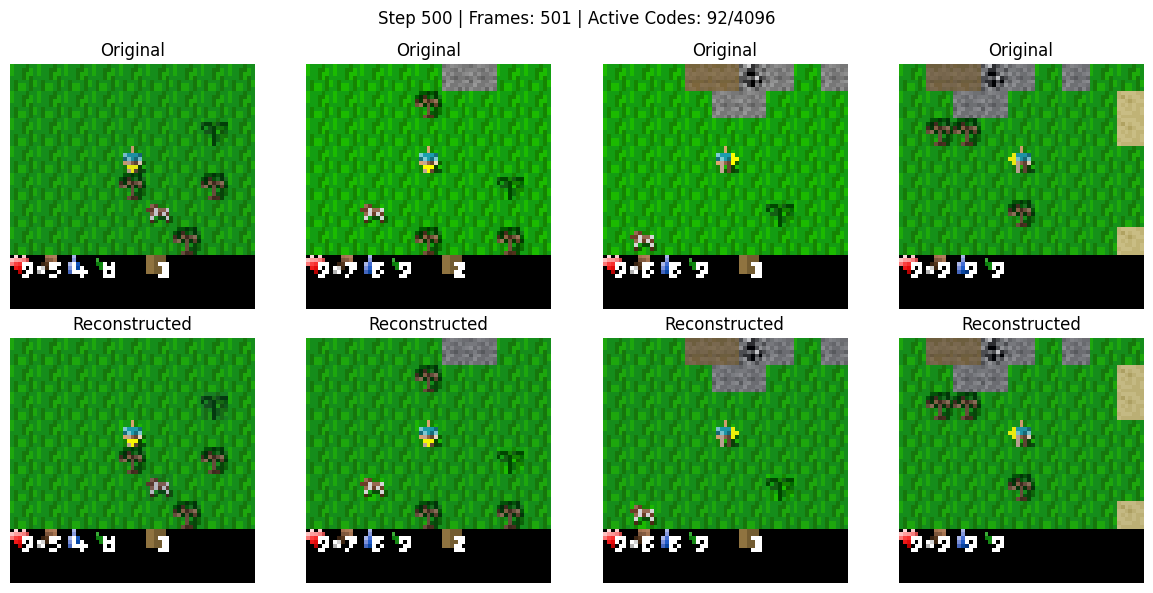

  Reconstruction MSE: 0.000780
Active codes: 92/4096 (2.2%)
Frames processed: 501


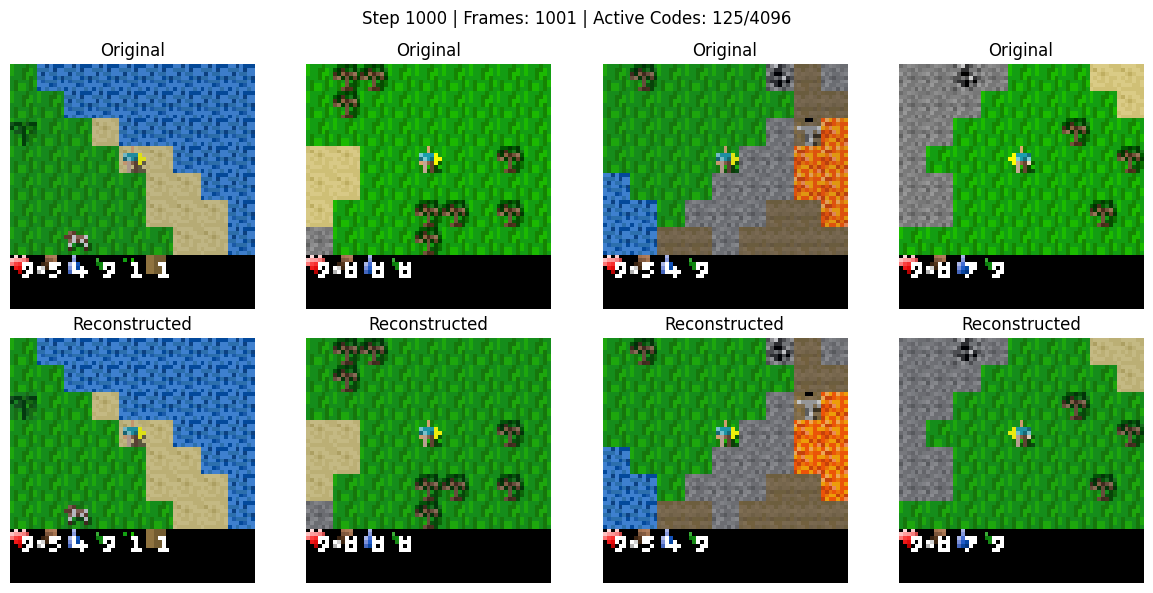

  Reconstruction MSE: 0.000961
Active codes: 125/4096 (3.1%)
Frames processed: 1001


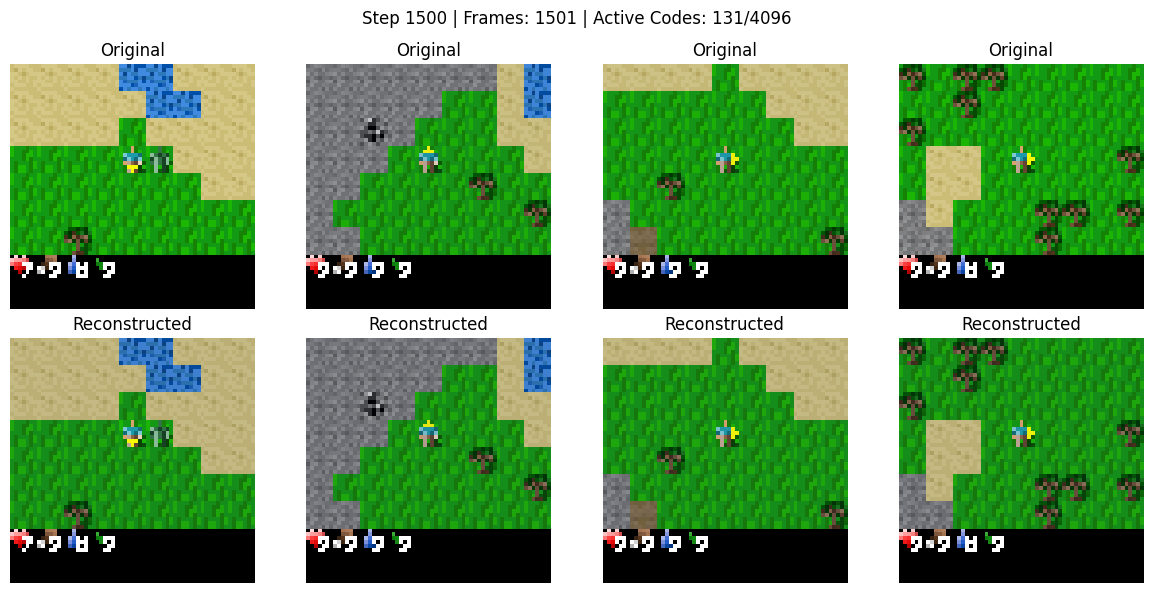

  Reconstruction MSE: 0.000947
Active codes: 131/4096 (3.2%)
Frames processed: 1501


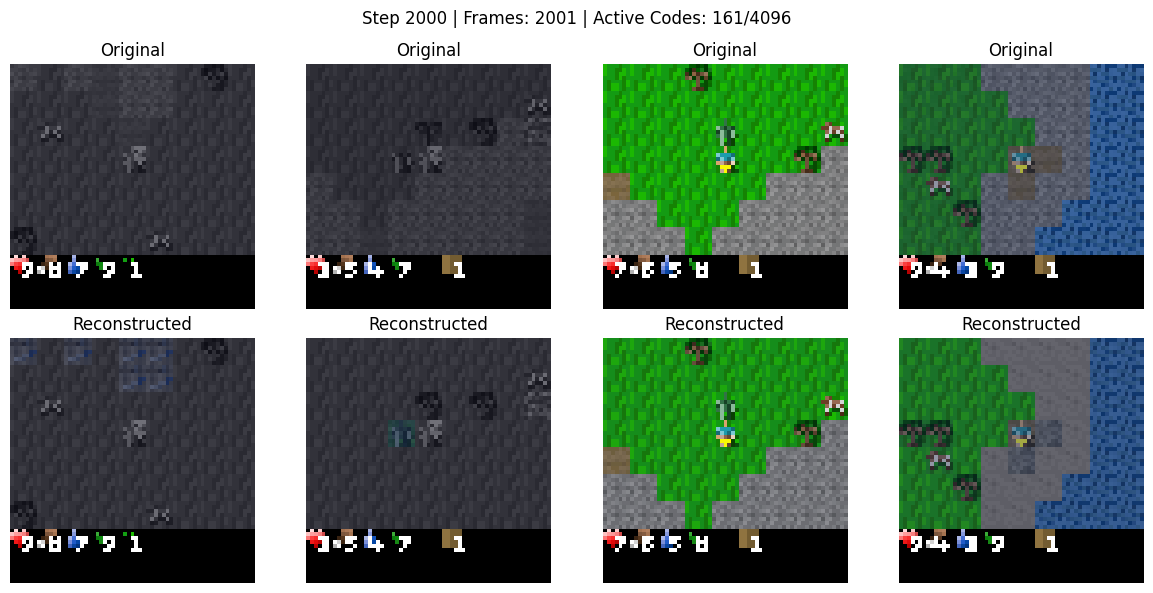

  Reconstruction MSE: 0.000809
Active codes: 161/4096 (3.9%)
Frames processed: 2001


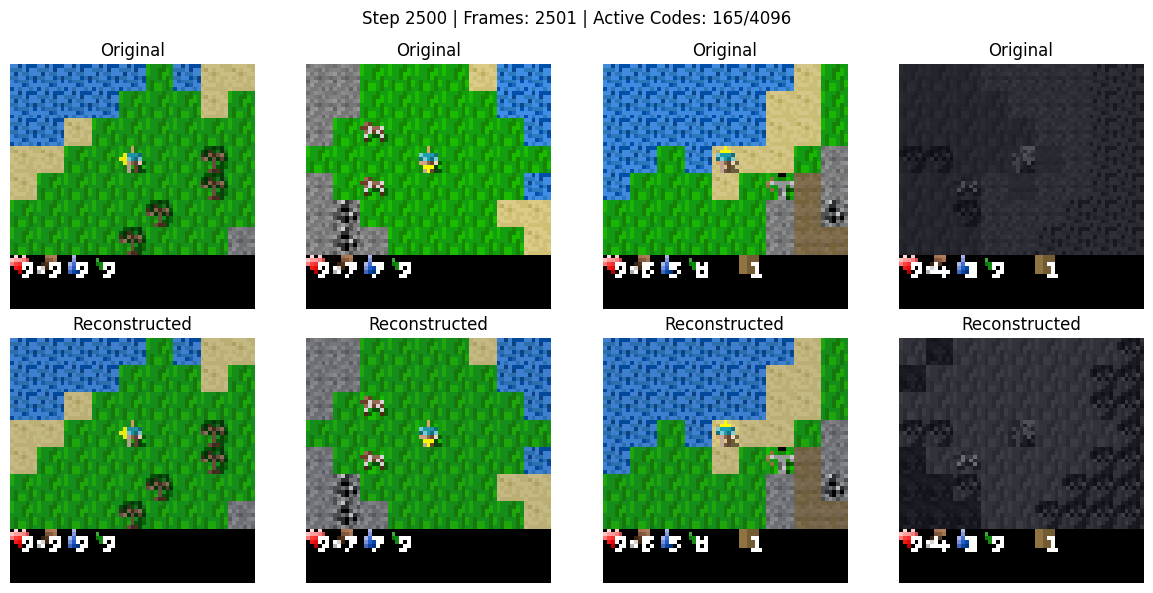

  Reconstruction MSE: 0.000762
Active codes: 165/4096 (4.0%)
Frames processed: 2501


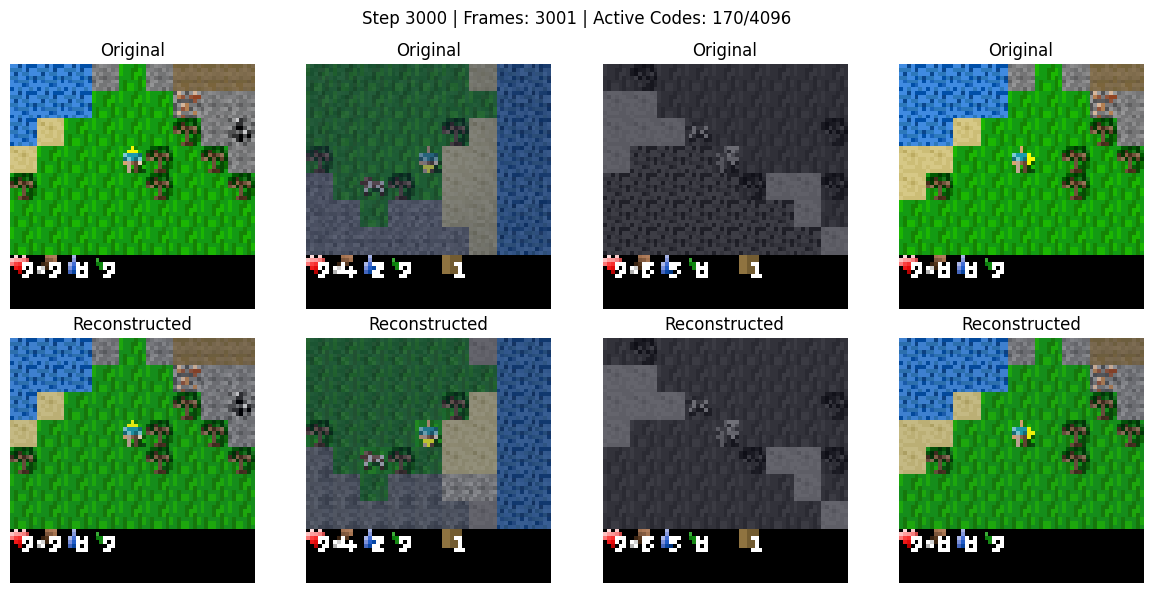

  Reconstruction MSE: 0.000581
Active codes: 170/4096 (4.2%)
Frames processed: 3001


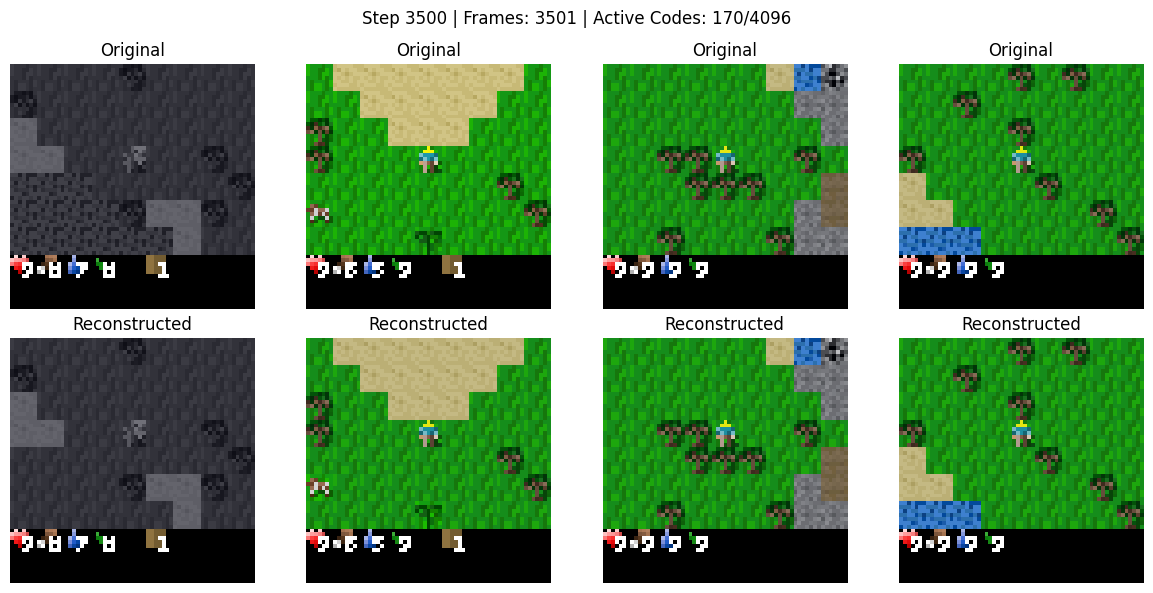

  Reconstruction MSE: 0.000697
Active codes: 170/4096 (4.2%)
Frames processed: 3501


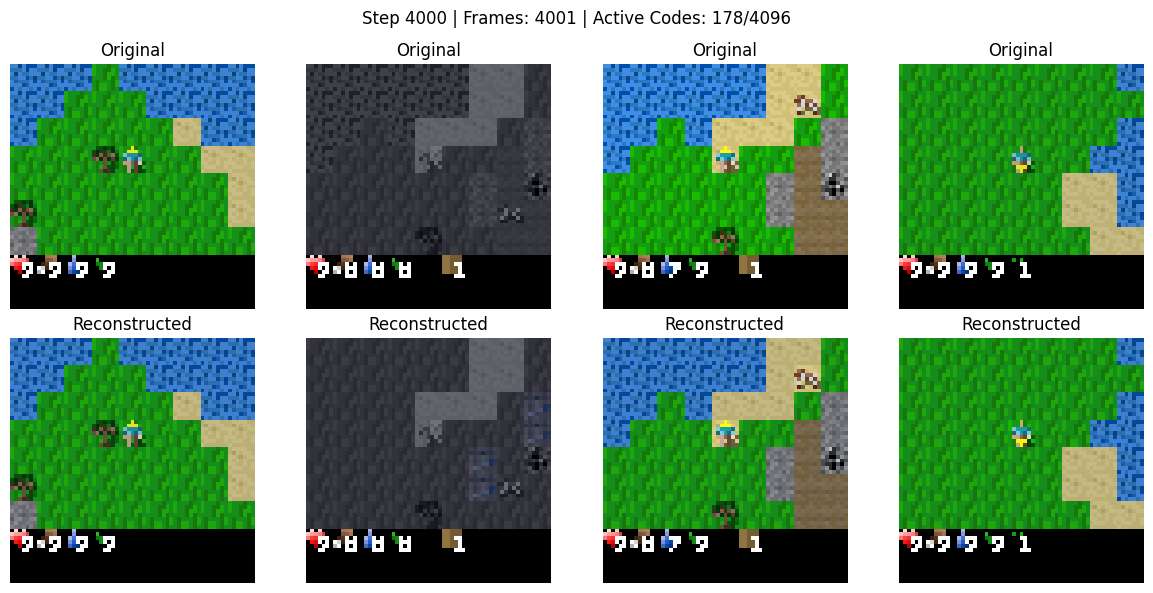

  Reconstruction MSE: 0.000808
Active codes: 178/4096 (4.3%)
Frames processed: 4001


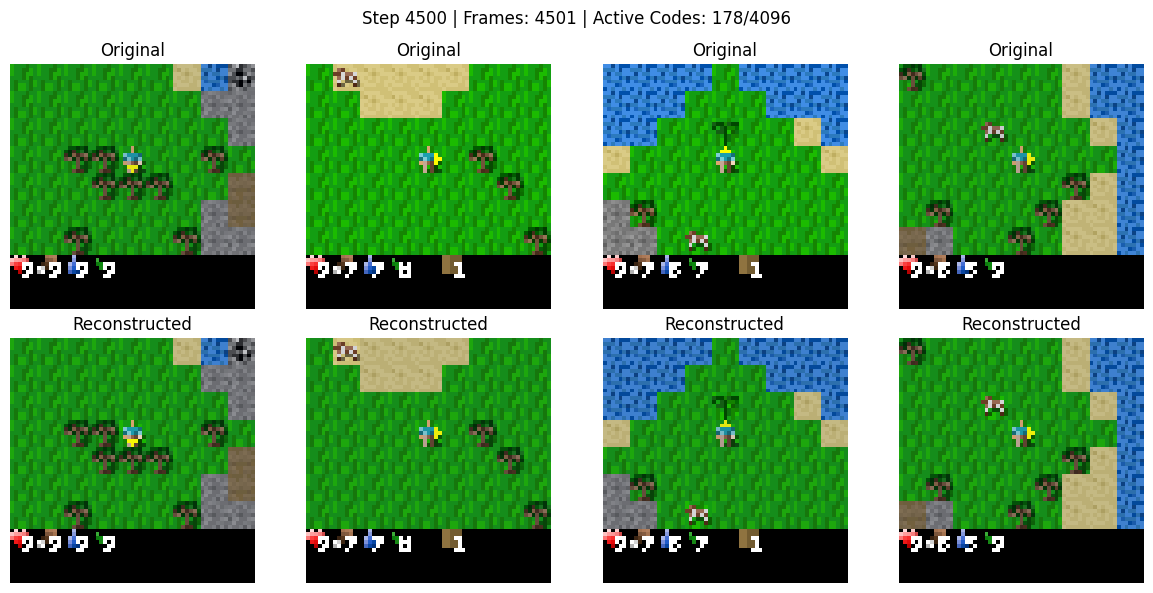

  Reconstruction MSE: 0.001024
Active codes: 178/4096 (4.3%)
Frames processed: 4501


In [ ]:
IMG_SIZE = 63
PATCH = 7
N_FRAMES = 5000
EVAL_EVERY = 500
BATCH_SIZE = 8
CODEBOOK_SIZE = 512
THRESHOLD = 0.75

key = jax.random.PRNGKey(42)
key, collect_key, tok_key = jax.random.split(key, 3)

frames = _collect_frames(N_FRAMES, IMG_SIZE, collect_key)

tokenizer = Tokenizer(
    dim=PATCH * PATCH * 3, thr=THRESHOLD, max_codes=CODEBOOK_SIZE, key=tok_key
)

print(f"\nStarting tokenizer evaluation...")
print(f"Patch size: {PATCH}x{PATCH}")
print(f"Frames size: {frames.shape}")
print(f"Codebook size: {CODEBOOK_SIZE}")
print(f"Threshold: {THRESHOLD}")
print("-" * 50)

for i in range(N_FRAMES):
    frame = frames[i : i + 1]
    frame_with_time = frame[:, :, None, :, :]

    tokenizer = tokenizer.update(frame_with_time, PATCH)

    if i > 0 and i % EVAL_EVERY == 0:
        key, sample_key = jax.random.split(key)
        batch = _sample_batch(frames, BATCH_SIZE, i, sample_key)
        batch_with_time = batch[:, :, None, :, :]

        codes = tokenizer(batch_with_time, PATCH)
        reconstructed = tokenizer.decode(codes, PATCH, 3).squeeze(2)

        active_codes = int(tokenizer.active.sum())
        mse = visualize_reconstruction(batch, reconstructed, i, i + 1, active_codes)

        print(
            f"Active codes: {active_codes}/{CODEBOOK_SIZE} ({100*active_codes/CODEBOOK_SIZE:.1f}%)"
        )
        print(f"Frames processed: {i+1}")
        print(f"Reconstruction MSE: {float(mse):.6f}")
